# 💳 Credit Card Fraud Detection - End-to-End Machine Learning Analysis

This notebook performs an **end-to-end Credit Card Fraud Detection** project using synthetic data.

### Key Steps:
1. Generate a realistic synthetic dataset (fraud vs. non-fraud)
2. Explore the data (EDA)
3. Handle imbalance using class weights or SMOTE
4. Train multiple ML models (Logistic Regression, Random Forest, Gradient Boosting)
5. Evaluate and compare models (ROC-AUC, F1, Precision, Recall)
6. Visualize results (ROC curves, confusion matrix, feature importances)
7. Predict future transactions and save results

---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, classification_report)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create output directory
OUT_DIR = os.path.join(os.getcwd(), 'credit_card_fraud_outputs')
os.makedirs(OUT_DIR, exist_ok=True)


In [3]:
# 1️⃣ Generate Synthetic Dataset
def generate_creditcard_data(n_samples=10000, fraud_ratio=0.02, seed=RANDOM_STATE):
    np.random.seed(seed)
    transaction_id = np.arange(1, n_samples + 1)
    amount = np.round(np.random.exponential(scale=100, size=n_samples), 2)
    transaction_time = np.random.randint(0, 86400, size=n_samples)
    merchant_category = np.random.choice(['Electronics', 'Grocery', 'Clothing', 'Fuel', 'Online', 'Travel'], size=n_samples)
    age = np.random.randint(18, 80, size=n_samples)
    card_type = np.random.choice(['Debit', 'Credit', 'Prepaid'], size=n_samples, p=[0.6, 0.35, 0.05])
    country = np.random.choice(['USA', 'UK', 'India', 'Germany', 'France', 'Canada'], size=n_samples)

    base_fraud = np.random.rand(n_samples) < fraud_ratio
    fraud = (
        (merchant_category == 'Online') & (np.random.rand(n_samples) < 0.15)
    ) | (amount > 800) | base_fraud
    fraud = fraud.astype(int)

    df = pd.DataFrame({
        'TransactionID': transaction_id,
        'Amount': amount,
        'TransactionTime': transaction_time,
        'MerchantCategory': merchant_category,
        'Age': age,
        'CardType': card_type,
        'Country': country,
        'Fraud': fraud
    })
    return df

df = generate_creditcard_data()
print('✅ Data Generated:', df.shape)
print(df.head())


✅ Data Generated: (10000, 8)
   TransactionID  Amount  TransactionTime MerchantCategory  Age CardType  \
0              1   46.93            60598           Online   39   Credit   
1              2  301.01            66399          Grocery   49    Debit   
2              3  131.67            27684      Electronics   41   Credit   
3              4   91.29            68591         Clothing   28   Credit   
4              5   16.96            77722           Online   28    Debit   

  Country  Fraud  
0     USA      0  
1     USA      0  
2  Canada      0  
3      UK      0  
4  France      0  


In [4]:

# 2️⃣ EDA
print('\nFraud distribution:\n', df['Fraud'].value_counts(normalize=True))
print('\nMissing values:\n', df.isnull().sum())



Fraud distribution:
 Fraud
0    0.9555
1    0.0445
Name: proportion, dtype: float64

Missing values:
 TransactionID       0
Amount              0
TransactionTime     0
MerchantCategory    0
Age                 0
CardType            0
Country             0
Fraud               0
dtype: int64


In [5]:
# 3️⃣ Feature Preparation
X = df.drop(columns=['TransactionID', 'Fraud'])
y = df['Fraud']

num_features = ['Amount', 'TransactionTime', 'Age']
cat_features = ['MerchantCategory', 'CardType', 'Country']

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', pd.get_dummies)])

X_encoded = pd.get_dummies(X, drop_first=True)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_encoded, y)
print('\nData balanced using SMOTE:', X_res.shape)



Data balanced using SMOTE: (19110, 15)


In [6]:
# 4️⃣ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=RANDOM_STATE, stratify=y_res)


In [7]:
# 5️⃣ Model Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

results = []
probas = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    probas[name] = y_proba
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values('ROC_AUC', ascending=False)
print('\n📊 Model Comparison:\n', results_df)

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f'🏆 Best Model: {best_model_name}')



📊 Model Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
1        RandomForest  0.959707   0.955410  0.964410  0.959889  0.992103
2    GradientBoosting  0.929356   0.916977  0.944173  0.930376  0.981547
0  LogisticRegression  0.895866   0.904745  0.884857  0.894690  0.963553
🏆 Best Model: RandomForest


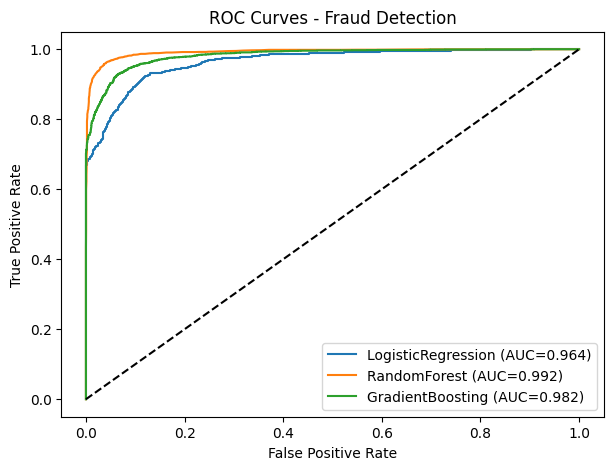

In [8]:
# 6️⃣ Visualizations
plt.figure(figsize=(7,5))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Fraud Detection')
plt.legend()
plt.show()


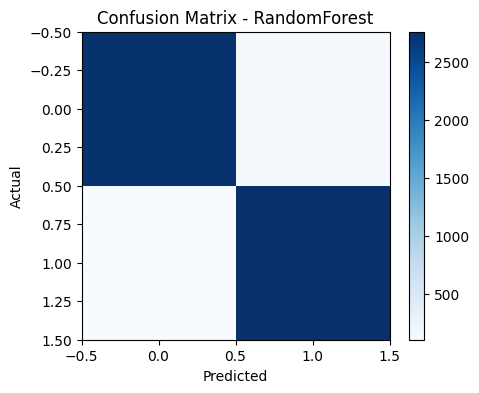

In [9]:
# Confusion Matrix for Best Model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [10]:

# 7️⃣ Future Predictions
new_data = df.sample(10).drop(columns=['Fraud'])
new_data_encoded = pd.get_dummies(new_data, drop_first=True).reindex(columns=X_encoded.columns, fill_value=0)
new_preds = best_model.predict_proba(new_data_encoded)[:, 1]
future_preds = new_data.copy()
future_preds['Fraud_Prob'] = new_preds
print('\n🔮 Future Fraud Predictions:\n', future_preds[['Amount','MerchantCategory','CardType','Fraud_Prob']])


🔮 Future Fraud Predictions:
       Amount MerchantCategory CardType  Fraud_Prob
5143  145.39             Fuel    Debit       0.030
8071   53.59             Fuel    Debit       0.165
3324  152.31          Grocery   Credit       0.020
6475  258.57           Travel  Prepaid       0.065
9806  134.25           Travel   Credit       0.000
578    67.75             Fuel   Credit       0.050
3506  362.62         Clothing    Debit       0.035
2078  419.90           Online    Debit       0.185
7707  143.56           Online    Debit       0.290
980    40.68      Electronics   Credit       0.005


In [11]:

# Save results
fraud_csv = os.path.join(OUT_DIR, 'credit_card_fraud_data.csv')
results_csv = os.path.join(OUT_DIR, 'credit_card_fraud_model_results.csv')
future_csv = os.path.join(OUT_DIR, 'credit_card_future_predictions.csv')

df.to_csv(fraud_csv, index=False)
results_df.to_csv(results_csv, index=False)
future_preds.to_csv(future_csv, index=False)

print('\n✅ Files saved:')
print(' -', fraud_csv)
print(' -', results_csv)
print(' -', future_csv)



✅ Files saved:
 - C:\Users\wwwdh\Desktop\analysis\Churn prediction\new Creditcard Analysis\credit_card_fraud_outputs\credit_card_fraud_data.csv
 - C:\Users\wwwdh\Desktop\analysis\Churn prediction\new Creditcard Analysis\credit_card_fraud_outputs\credit_card_fraud_model_results.csv
 - C:\Users\wwwdh\Desktop\analysis\Churn prediction\new Creditcard Analysis\credit_card_fraud_outputs\credit_card_future_predictions.csv
